# Huy Le

# Set up code

In [116]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load data
train_df = pd.read_csv("housing/train.csv")
test_df  = pd.read_csv("housing/test.csv")

# Helper metrics functions
def mse(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.mean((y_true - y_pred) ** 2)

def r2(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    # Handle edge case where ss_tot == 0 (constant y)
    return 1.0 - (ss_res / ss_tot) if ss_tot != 0 else 0.0

TARGET = "price"

# Columns to exclude (non-features)
AUTO_EXCLUDE = {"Unnamed: 0", "id", "date"}
EXCLUDE_FEATURES = set()  # add assignment-excluded feature names here

# Build train X/y
exclude_cols = AUTO_EXCLUDE | EXCLUDE_FEATURES
drop_train = [c for c in ([TARGET] + list(exclude_cols)) if c in train_df.columns]

y_train = train_df[TARGET].values
X_train = train_df.drop(columns=drop_train)


# Build test X/y (if price exists)
y_test = None
drop_test = [c for c in ([TARGET] + list(exclude_cols)) if c in test_df.columns]

if TARGET in test_df.columns:
    y_test = test_df[TARGET].values
    X_test = test_df.drop(columns=drop_test)
else:
    X_test = test_df.drop(columns=[c for c in exclude_cols if c in test_df.columns])

# Align columns
common_cols = [c for c in X_train.columns if c in X_test.columns]
X_train = X_train[common_cols]
X_test  = X_test[common_cols]

print(f"Using {len(common_cols)} features:")
print(common_cols)

Using 18 features:
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


# Question 1

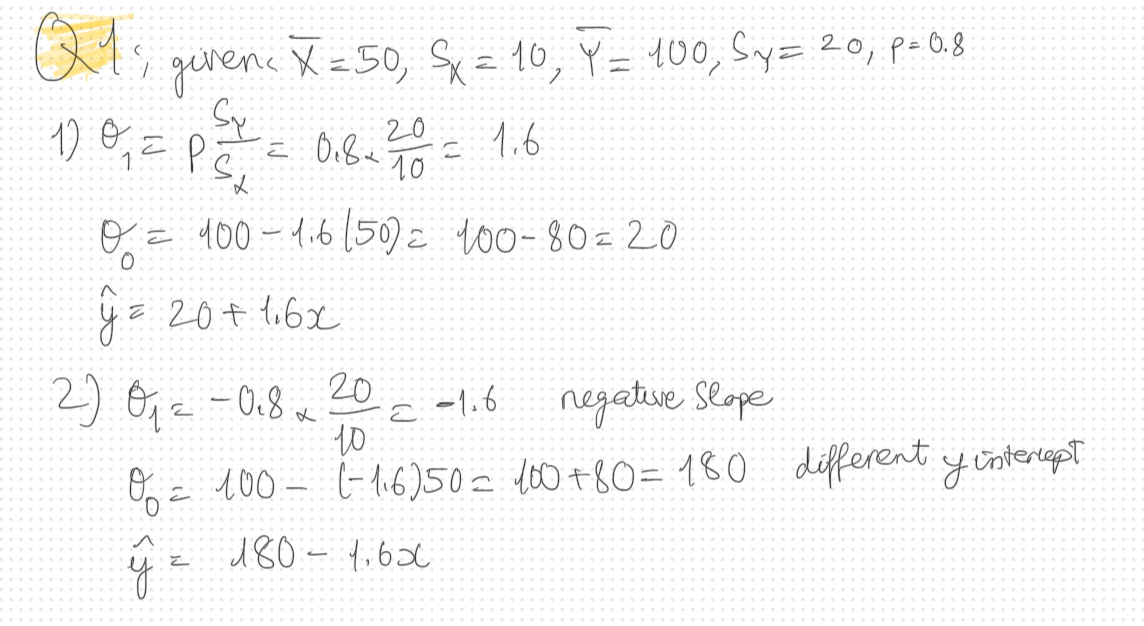

# Question 2

In [117]:
# Train package model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Coefficients
coef_df = pd.DataFrame({
    "feature": common_cols,
    "coefficient": lr.coef_
})
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False).drop(columns=["abs_coef"])

print("\nCoefficients")
print(f"Intercept: {lr.intercept_}")
print(coef_df.to_string(index=False))


# Training metrics
train_pred = lr.predict(X_train)
train_mse = mse(y_train, train_pred)
train_r2  = r2(y_train, train_pred)

print("\nTraining Metrics")
print(f"Train MSE: {train_mse}")
print(f"Train R^2: {train_r2}")

test_pred = lr.predict(X_test)

if y_test is not None:
    test_mse = mse(y_test, test_pred)
    test_r2  = r2(y_test, test_pred)

    print("\nTesting Metrics")
    print(f"Test MSE: {test_mse}")
    print(f"Test R^2: {test_r2}")
else:
    print("\nTest set has no 'price' column; printing first 10 predictions only:")
    print(test_pred[:10])


Coefficients
Intercept: 12875953.323038455
      feature   coefficient
   waterfront 714809.861584
          lat 584409.332119
        grade  80108.981509
         long -75589.728454
         view  64888.715104
    bathrooms  25607.794233
       floors  21086.627238
     bedrooms -16666.952240
    condition  16397.632749
     yr_built  -2584.553883
      zipcode   -462.794358
  sqft_living     82.454575
sqft_living15     62.042829
 yr_renovated     42.752840
   sqft_above     42.428171
sqft_basement     40.026404
   sqft_lot15     -0.446745
     sqft_lot      0.365778

Training Metrics
Train MSE: 31119892883.73363
Train R^2: 0.7297146363422669

Testing Metrics
Test MSE: 57161532843.1485
Test R^2: 0.6571548065193994


## biggest drivers were: 

grade (strong positive impact), lat (location matters a lot), yr_built (new constructions have higher prices), waterfront, sqft_living, view, sqft_above / sqft_basement, sqft_living15

## Model fits well? 
Moderately well:
𝑅2 ≈ 0.73 means ~73% of training variance.
𝑅2 ≈0.66 on testing is still solid, but lower.

## How large is the model error?
Based on RMSE: About $176k on training, and about $239k on testing

## Train vs test MSE relationship

Test MSE is higher than train MSE (also RMSE is higher), indicating some overfitting. The model fits training better than real data.

# Question 3

In [118]:
# Closed-form fit/predict
def fit_closed_form(X, y):
    """
    Closed-form least squares with intercept via bias column.
    theta = pinv([1, X]) y
    Returns theta where:
      theta[0] = intercept
      theta[1:] = coefficients
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1)

    Xb = np.c_[np.ones((X.shape[0], 1)), X]   # add intercept column
    theta = np.linalg.pinv(Xb) @ y
    return theta

def predict_closed_form(X, theta):
    X = np.asarray(X, dtype=float)
    theta = np.asarray(theta, dtype=float).reshape(-1)
    Xb = np.c_[np.ones((X.shape[0], 1)), X]
    return Xb @ theta

# Train closed-form
theta_cf = fit_closed_form(X_train.values, y_train)

# Predict function for ONE new testing point
def predict_one_point(row: pd.Series, theta: np.ndarray, feature_order: list) -> float:
    """
    row: Series containing the feature columns (or a row from the original df)
    theta: closed-form parameters
    feature_order: list of columns used in training (common_cols)
    """
    x = row[feature_order].values.astype(float)
    x_b = np.r_[1.0, x]  # add bias term
    return float(x_b @ theta)

# Predictions
pred_train_cf = predict_closed_form(X_train.values, theta_cf)
pred_test_cf  = predict_closed_form(X_test.values, theta_cf)

# Metrics (closed-form)
train_mse_cf = mse(y_train, pred_train_cf)
train_r2_cf  = r2(y_train, pred_train_cf)
test_mse_cf  = mse(y_test, pred_test_cf)
test_r2_cf   = r2(y_test, pred_test_cf)

print("\nClosed-form")
print(f"Train MSE: {train_mse_cf}")
print(f"Train R^2: {train_r2_cf}")
print(f"Test  MSE: {test_mse_cf}")
print(f"Test  R^2: {test_r2_cf}")

# Print coefficients
intercept_cf = theta_cf[0]
coefs_cf = theta_cf[1:]

coef_table_cf = pd.DataFrame({
    "feature": common_cols,
    "coef_closed_form": coefs_cf
})
coef_table_cf["abs_coef"] = coef_table_cf["coef_closed_form"].abs()
coef_table_cf = coef_table_cf.sort_values("abs_coef", ascending=False).drop(columns=["abs_coef"])

print("\nClosed-form intercept:", intercept_cf)
print("Closed-form coefficients (sorted by |coef|):")
print(coef_table_cf.to_string(index=False))


# sklearn comparison model
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_train_lr = lr.predict(X_train)
pred_test_lr  = lr.predict(X_test)

train_mse_lr = mse(y_train, pred_train_lr)
train_r2_lr  = r2(y_train, pred_train_lr)
test_mse_lr  = mse(y_test, pred_test_lr)
test_r2_lr   = r2(y_test, pred_test_lr)

print("\nsklearn LinearRegression (Problem 2)")
print(f"Train MSE: {train_mse_lr}")
print(f"Train R^2: {train_r2_lr}")
print(f"Test  MSE: {test_mse_lr}")
print(f"Test  R^2: {test_r2_lr}")

# Similarity checks
max_train_pred_diff = np.max(np.abs(pred_train_lr - pred_train_cf))
max_test_pred_diff  = np.max(np.abs(pred_test_lr - pred_test_cf))
intercept_diff      = abs(lr.intercept_ - intercept_cf)
max_coef_diff       = np.max(np.abs(lr.coef_ - coefs_cf))

print("\nSimilarity Check (Closed-form vs sklearn)")
print(f"Max |train prediction diff|: {max_train_pred_diff:e}")
print(f"Max |test  prediction diff|: {max_test_pred_diff:e}")
print(f"|intercept diff|:          {intercept_diff:e}")
print(f"Max |coef diff|:           {max_coef_diff:e}")



Closed-form
Train MSE: 31119892883.733593
Train R^2: 0.7297146363422672
Test  MSE: 57161532843.15728
Test  R^2: 0.6571548065193468

Closed-form intercept: 12875953.32303109
Closed-form coefficients (sorted by |coef|):
      feature  coef_closed_form
   waterfront     714809.861584
          lat     584409.332119
        grade      80108.981509
         long     -75589.728454
         view      64888.715104
    bathrooms      25607.794233
       floors      21086.627238
     bedrooms     -16666.952240
    condition      16397.632749
     yr_built      -2584.553883
      zipcode       -462.794358
  sqft_living         82.444059
sqft_living15         62.042829
 yr_renovated         42.752840
   sqft_above         42.438687
sqft_basement         40.036921
   sqft_lot15         -0.446745
     sqft_lot          0.365778

sklearn LinearRegression (Problem 2)
Train MSE: 31119892883.73363
Train R^2: 0.7297146363422669
Test  MSE: 57161532843.1485
Test  R^2: 0.6571548065193994

Similarity Check 

## similarity with the results of sklearn

My metrics are essentially identical (small differences in numerical precision), which makes sense because sklearn.LinearRegression also solves the same least-squares problem.

# Question 4

In [119]:
# Closed-form linear regression (from Problem 3)
# theta = pinv([1, X]) y
def fit_closed_form(X, y):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1)

    # add bias column for intercept
    Xb = np.c_[np.ones((X.shape[0], 1)), X]
    theta = np.linalg.pinv(Xb) @ y
    return theta

def predict_closed_form(X, theta):
    X = np.asarray(X, dtype=float)
    theta = np.asarray(theta, dtype=float).reshape(-1)

    Xb = np.c_[np.ones((X.shape[0], 1)), X]
    return Xb @ theta


# Polynomial feature builder
# For degree p, features are [X, X^2, ..., X^p]
def make_poly_features(x, p):
    x = np.asarray(x, dtype=float).reshape(-1, 1)
    return np.hstack([x ** k for k in range(1, p + 1)])


# Predict function for ONE new point
def predict_one_point_sqft_living(x_value, theta, p):
    # build [x, x^2, ..., x^p] for one point
    feats = np.array([x_value ** k for k in range(1, p + 1)], dtype=float)
    # prepend 1 for intercept
    xb = np.r_[1.0, feats]
    return float(xb @ theta)

# Feature X and response Y
X_train_raw = train_df["sqft_living"].values
y_train = train_df["price"].values

X_test_raw = test_df["sqft_living"].values
y_test = test_df["price"].values

# Train/evaluate for p <= 4
results = []
for p in range(1, 5):
    X_train_poly = make_poly_features(X_train_raw, p)
    X_test_poly  = make_poly_features(X_test_raw, p)

    theta = fit_closed_form(X_train_poly, y_train)

    pred_train = predict_closed_form(X_train_poly, theta)
    pred_test  = predict_closed_form(X_test_poly, theta)

    results.append({
        "degree_p": p,
        "train_MSE": mse(y_train, pred_train),
        "train_R2":  r2(y_train, pred_train),
        "test_MSE":  mse(y_test, pred_test),
        "test_R2":   r2(y_test, pred_test),
    })

results_df = pd.DataFrame(results)

# Print table
print("\nPolynomial Regression Results (X = sqft_living)")
print(results_df.to_string(index=False))



Polynomial Regression Results (X = sqft_living)
 degree_p    train_MSE  train_R2     test_MSE   test_R2
        1 5.794753e+10  0.496709 8.857598e+10  0.468736
        2 5.482267e+10  0.523849 7.179168e+10  0.569406
        3 5.378519e+10  0.532860 9.983348e+10  0.401216
        4 5.279585e+10  0.541453 2.497187e+11 -0.497770


## How the MSE and $R^2$ metrics change with the degree of the polynomial.
- Training: As 𝑝 increases from 1 to 4, train MSE decreases and train 𝑅2 increases slightly therefore the model fits training data better.
- Testing: The best test performance here is 𝑝 = 2(lowest test MSE, highest test 𝑅2).
For 𝑝 ≥ 3 test MSE worsens. For 𝑝 = 4,5 test 𝑅2 becomes negative: the model is doing worse 
- Why: higher-degree polynomials with sqft_living (values in the thousands) can become numerically unstable and overfit

# Question 5

In [120]:
# Feature scaling for stable gradient descent
# (z-score using training mean/std)
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0, ddof=0)
sigma_safe = np.where(sigma == 0, 1.0, sigma)

X_train_std = (X_train - mu) / sigma_safe
X_test_std  = (X_test - mu) / sigma_safe

def add_bias(X):
    return np.c_[np.ones((X.shape[0], 1)), X]

Xtr_b = add_bias(X_train_std)
Xte_b = add_bias(X_test_std)

# Gradient Descent for linear regression
# Using MSE objective: J(theta) = (1/n) * ||Xb*theta - y||^2
# Gradient: (2/n) * Xb^T (Xb*theta - y)
def gradient_descent(Xb, y, alpha, num_iters, theta0=None):
    n, d = Xb.shape
    if theta0 is None:
        theta = np.zeros(d, dtype=float)
    else:
        theta = np.asarray(theta0, dtype=float).copy()

    for _ in range(num_iters):
        pred = Xb @ theta
        err = pred - y
        grad = (2.0 / n) * (Xb.T @ err)
        theta -= alpha * grad
    return theta

# Vary alpha and iterations; report theta + metrics
alphas = [0.01, 0.1, 0.5]
iters_list = [10, 50, 100]

rows = []
for alpha in alphas:
    for iters in iters_list:
        theta = gradient_descent(Xtr_b, y_train, alpha=alpha, num_iters=iters)

        # Predictions
        pred_train = Xtr_b @ theta
        pred_test  = Xte_b @ theta

        # Metrics
        train_mse = mse(y_train, pred_train)
        train_r2  = r2(y_train, pred_train)
        test_mse  = mse(y_test, pred_test)
        test_r2   = r2(y_test, pred_test)

        # Report results
        rows.append({
            "alpha": alpha,
            "iters": iters,
            "theta0(intercept)": theta[0],
            "theta_L2_norm": float(np.linalg.norm(theta)),
            "train_MSE": train_mse,
            "train_R2": train_r2,
            "test_MSE": test_mse,
            "test_R2": test_r2,
        })

results_df = pd.DataFrame(rows).sort_values(["alpha", "iters"])
print("\nGradient Descent Results")
print(results_df.to_string(index=False))



Gradient Descent Results
 alpha  iters  theta0(intercept)  theta_L2_norm     train_MSE       train_R2      test_MSE        test_R2
  0.01     10       9.519802e+04   1.221672e+05  2.357470e+11  -1.047532e+00  2.806690e+11  -6.834052e-01
  0.01     50       3.308955e+05   3.633530e+05  6.975306e+10   3.941743e-01  9.704644e+10   4.179319e-01
  0.01    100       4.513976e+05   4.823637e+05  3.668105e+10   6.814144e-01  6.323335e+10   6.207371e-01
  0.10     10       4.645357e+05   4.953316e+05  3.495339e+10   6.964196e-01  6.151979e+10   6.310147e-01
  0.10     50       5.204074e+05   5.542358e+05  3.113247e+10   7.296054e-01  5.726716e+10   6.565213e-01
  0.10    100       5.204148e+05   5.549547e+05  3.112017e+10   7.297122e-01  5.717304e+10   6.570858e-01
  0.50     10       5.204148e+05   2.173757e+11  2.523546e+23  -2.191774e+12  2.790568e+23  -1.673735e+12
  0.50     50      -1.308766e+21   6.904816e+36  2.546205e+74  -2.211453e+63  2.815623e+74  -1.688763e+63
  0.50    100      -

## How do the metrics change with different learning rates; 
- Small learning rate (α = 0.01): Metrics improve slowly as iterations increase.
- Medium learning rate (α = 0.10): Metrics improve fast.
- Large learning rate (α = 0.50): Metrics become very large or small (diverge).
## How many iterations are needed

α = 0.1: about 50 iterations is enough (metrics at 50 and 100 are nearly the same).

α = 0.01: needs more than 100 to reach the same neighborhood (100 is improved but still slower).

α = 0.5: doesn’t need more iterations because it won’t converge because it diverges.

-> ~50 iterations (with α=0.1 and standardized features) is enough.
## Does the algorithm converge to the optimal solution
Yes, when α is in a stable range (like 0.1, also eventually 0.01). Train/Test MSE and 𝑅2 stop changing (stabilize), and match the closed-form solution very closely.

# Question 6

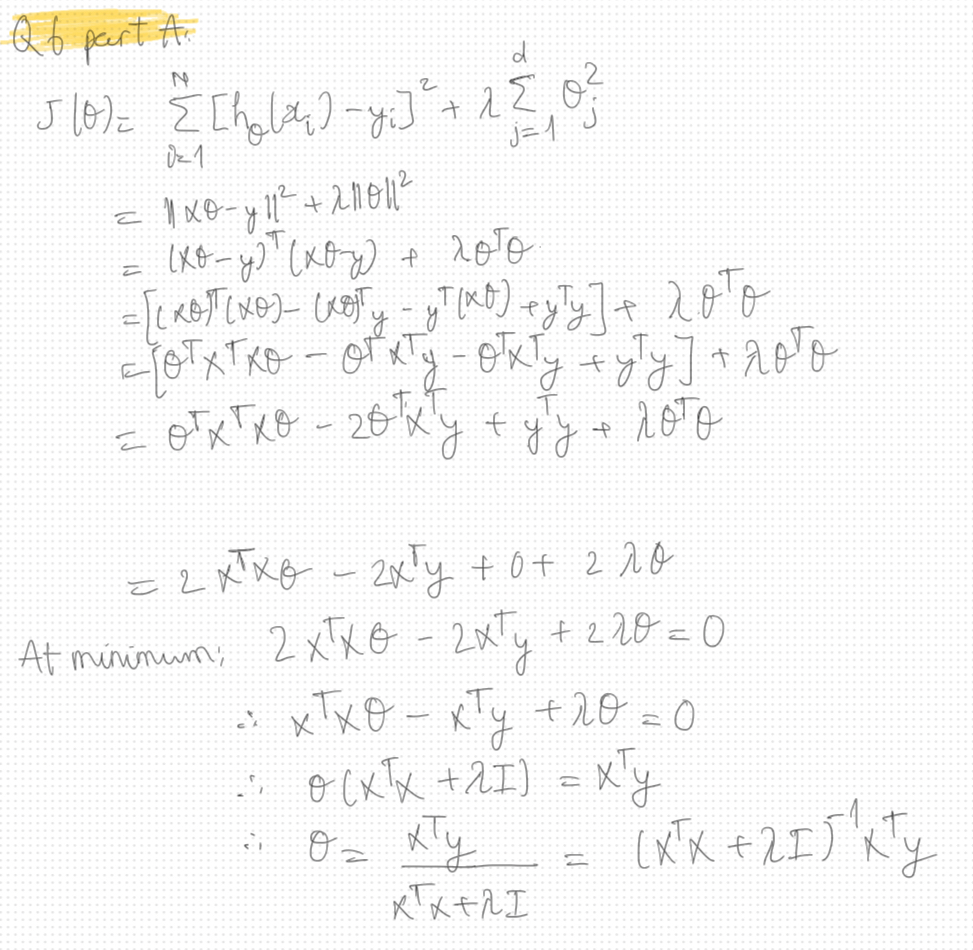

In [121]:
X_train = X_train[common_cols].astype(float).values
X_test = X_test[common_cols].astype(float).values

# Standardize features
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0, ddof=0)
sigma_safe = np.where(sigma == 0, 1.0, sigma)

X_train_std = (X_train - mu) / sigma_safe
X_test_std  = (X_test - mu) / sigma_safe

def add_bias(X):
    return np.c_[np.ones((X.shape[0], 1)), X]

Xtr_b = add_bias(X_train_std)
Xte_b = add_bias(X_test_std)


# Ridge Gradient Descent
# Objective (conceptually): (1/N)||Xθ - y||^2 + λ * ||θ_{1:}||^2
# Gradient: (2/N) X^T (Xθ - y) + 2λ*[0, θ1..θd]
def ridge_gradient_descent(Xb, y, alpha, num_iters, lmbda, theta0=None):
    n, d = Xb.shape
    if theta0 is None:
        theta = np.zeros(d, dtype=float)
    else:
        theta = np.asarray(theta0, dtype=float).copy()

    for _ in range(num_iters):
        err = (Xb @ theta) - y
        grad_data = (2.0 / n) * (Xb.T @ err)

        # regularize all except intercept
        grad_reg = np.r_[0.0, 2.0 * lmbda * theta[1:]]

        theta -= alpha * (grad_data + grad_reg)

    return theta

# Closed-form linreg and Ridge (intercept NOT regularized)
def linreg_closed_form(Xb, y):
    """
    linreg: theta = pinv(Xb) y
    Xb includes intercept column.
    """
    return np.linalg.pinv(Xb) @ y

def ridge_closed_form(Xb, y, lmbda):
    """
    Ridge (do NOT regularize intercept):
    theta = (Xb^T Xb + lambda R)^(-1) Xb^T y
    where R = diag(0,1,1,...,1)
    """
    d = Xb.shape[1]
    R = np.eye(d)
    R[0, 0] = 0.0  # no penalty on intercept
    return np.linalg.solve(Xb.T @ Xb + lmbda * R, Xb.T @ y)

# Requirement: Simulate data
# N=1000, Xi ~ Uniform[-2,2], ei ~ N(0,2), Yi = 1 + 2Xi + ei
# Note: N(0,2) means variance=2, so std = sqrt(2)
np.random.seed(0)
N = 1000

X = np.random.uniform(-2, 2, size=N)
e = np.random.normal(0, np.sqrt(2), size=N)
Y = 1 + 2 * X + e

# Design matrix with intercept
Xb = np.c_[np.ones(N), X]


# Fit linreg + Ridge for lambdas and print slope, MSE, R^2
lambdas = [1, 10, 100, 1000, 10000]
rows = []

# Linear Regression
theta_ols = linreg_closed_form(Xb, Y)      # [intercept, slope]
Yhat_ols = Xb @ theta_ols
rows.append({
    "model": "Linear",
    "lambda": 0,
    "intercept": theta_ols[0],
    "slope": theta_ols[1],
    "MSE": mse(Y, Yhat_ols),
    "R2": r2(Y, Yhat_ols),
})

# Ridge
for lmbda in lambdas:
    theta_r = ridge_closed_form(Xb, Y, lmbda)
    Yhat_r = Xb @ theta_r
    rows.append({
        "model": "Ridge",
        "lambda": lmbda,
        "intercept": theta_r[0],
        "slope": theta_r[1],
        "MSE": mse(Y, Yhat_r),
        "R2": r2(Y, Yhat_r),
    })

results_df = pd.DataFrame(rows)
print("\n Linear Regression vs Ridge Regression")
print(results_df.to_string(index=False))



 Linear Regression vs Ridge Regression
 model  lambda  intercept    slope      MSE       R2
Linear       0   1.040515 1.965692 1.865374 0.736759
 Ridge       1   1.040491 1.964238 1.865377 0.736759
 Ridge      10   1.040279 1.951251 1.865656 0.736720
 Ridge     100   1.038305 1.830236 1.890166 0.733261
 Ridge    1000   1.026876 1.129641 2.809812 0.603481
 Ridge   10000   1.012264 0.233982 5.917267 0.164958


## when 𝜆 changes: 
- as 𝜆 increases: Slope decreases, Intercept moves toward the average 𝑌
- for very large 𝜆: MSE increases and 𝑅2 decreases because the model becomes too constrained (high bias).
- for 𝜆 = 0 to 100: the ridge MSE and R2 are slightly similar to those of linreg.